# Live-updating multi-tau one-time correlation with synthetic and real data

In [1]:
# analysis tools from scikit-beam (https://github.com/scikit-beam/scikit-beam/tree/master/skbeam/core)
import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

from lmfit import Model

# plotting tools from xray_vision (https://github.com/Nikea/xray-vision/blob/master/xray_vision/mpl_plotting/roi.py)
import xray_vision.mpl_plotting as mpl_plot  

import numpy as np
import os, sys
import zipfile

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
%matplotlib notebook

In [5]:
interactive_mode = True

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

%run download.py

__file__
current_folder = /Volumes/Data/ipython_NoteBooks/my_ipy_notebook/NYSDS
current_folder = /Volumes/Data/ipython_NoteBooks/my_ipy_notebook/NYSDS


In [3]:
data_dir = "Duke_data/"
duke_rdata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_rdata.shape[0]):
    duke_data.append(duke_rdata[i] - duke_dark)
    
duke_ndata=np.asarray(duke_data)

# load the mask(s) and mask the data
mask1 = np.load(data_dir+"new_mask4.npy")
mask2 = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask1 + mask2)
mask_data = N_mask*duke_ndata

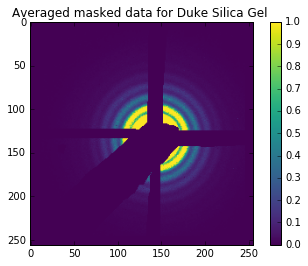

In [4]:
#  get the average image
avg_img = np.average(duke_ndata, axis=0)

# if matplotlib version 1.5 or later
if float('.'.join(mpl.__version__.split('.')[:2])) >= 1.5:
    cmap = 'viridis'
else:
    cmap = 'Dark2'

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap= cmap )
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

In [6]:
inner_radius = 24  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 5    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_val = utils.twotheta_to_q(two_theta, lambda_)

q_val

array([[ 0.00243251,  0.00253387],
       [ 0.00253387,  0.00263522],
       [ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929]])

In [7]:
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.00248319,  0.00258455,  0.0026859 ,  0.00278726,  0.00288861])

<IPython.core.display.Javascript object>


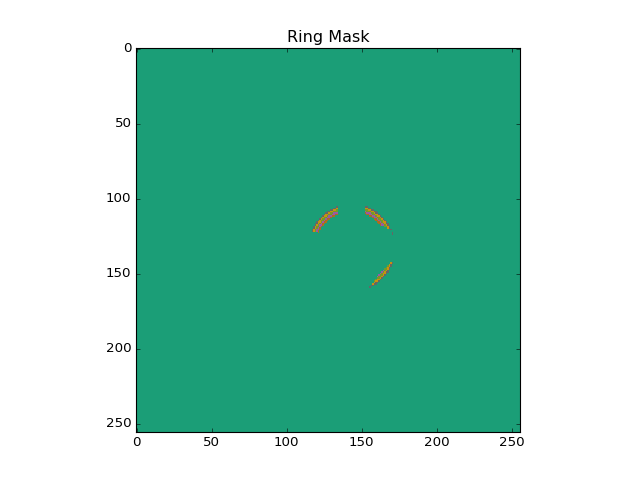

In [9]:
rings = roi.rings(edges, center, avg_img.shape)

mask_data2 = N_mask*duke_data[0:4999]

ring_mask = rings*N_mask

# plot the figure
fig, axes = plt.subplots()
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, ring_mask, cmap="Dark2")
plt.show()


In [10]:
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

exposuretime=0.001;
deadtime=60e-6;
timeperframe = exposuretime+deadtime
lags = lag_steps*timeperframe

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


### Define a helper function to process and update the live plot

In [12]:
def update_plot(ax, g2s, lags, img_num):
    ax.cla()
    for n, g2 in enumerate(g2s.T):
        ax.plot(lags[:len(g2)], g2, '-o', label='roi%s' % n)
    ax.set_title('processed %s images' % img_num)
    ax.legend(loc=0)
    ax.set_xlabel('Log time (s)')
    ax.set_ylabel('Correlation')
    try:
        ax.set_xscale('log')
        ax.figure.canvas.draw()
    except ValueError:
        # this happens on the first few draws
        ax.set_xscale('linear')
        ax.figure.canvas.draw()
    ttime.sleep(0.001)

## Show the correlator working with synthetic data

In [5]:
corr_gen = lazy_one_time(synthetic_data, num_levels, num_bufs, rois)
for counter, res in enumerate(corr_gen):
    # only update the plot every 5th image processed.
    if counter % 5 == 0:
        update_plot(ax, res.g2, res.lag_steps, counter)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


## Now let's do it with some real data

### Use the class-based partial data correlator in scikit-beam

<IPython.core.display.Javascript object>


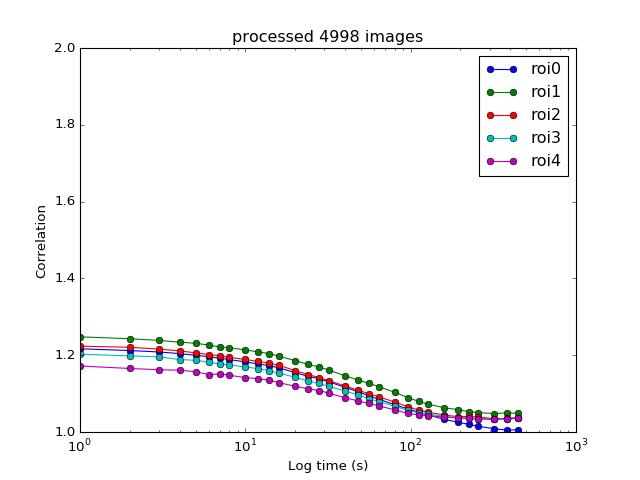

In [11]:
fig2, ax2 = plt.subplots()
ax2.set_xscale('log')

#### Show incremental updates with the generator implementation of the correlator

In [15]:
import time as ttime
gen = corr.lazy_one_time(mask_data2, num_levels, num_bufs, ring_mask)
for counter, result in enumerate(gen):
    # update image every 10th image for performance
    if counter % 10 == 0:
        update_plot(ax2, result.g2, result.lag_steps, counter)
else:
    # do a final update to get the last bit
    update_plot(ax2, result.g2, result.lag_steps, counter)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


In [16]:
gen = corr.lazy_one_time(mask_data2, num_levels, num_bufs, ring_mask)
gen

<generator object lazy_one_time at 0x116c1fb88>

In [17]:
import copy
result_g2 = []
lag = []
for result in gen:
    r_g2 = copy.copy(result.g2)
    lags = copy.copy(result.lag_steps)
    result_g2.append(r_g2)
    lag.append(lags)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


In [18]:
result.lag_steps

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  14,  16,
        20,  24,  28,  32,  40,  48,  56,  64,  80,  96, 112, 128, 160,
       192, 224, 256, 320, 384, 448])

In [16]:
lag[0], lag[1], lag[5]

(array([0]), array([0, 1]), array([0, 1, 2, 3, 4, 5]))

In [17]:
result_g2[0].shape, result_g2[1].shape, result_g2[5].shape

((1, 3), (2, 3), (6, 3))

<IPython.core.display.Javascript object>


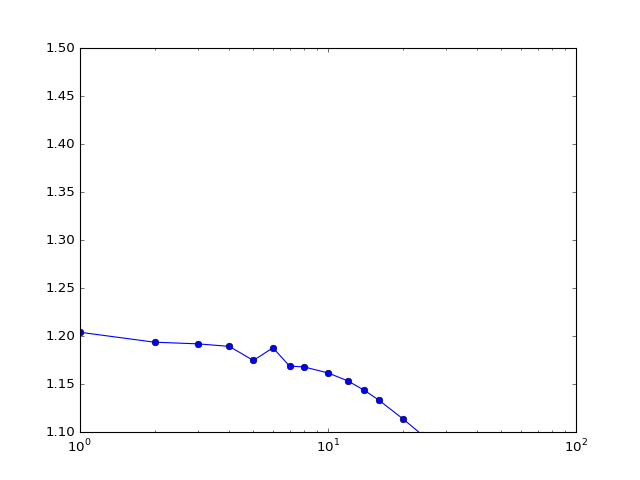

In [19]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(lag[20], result_g2[20][:,2], "-o") 
ax.set_xscale('log')


def animate(i):
    line1.set_xdata(lag[i])
    line1.set_ydata(result_g2[i][:, 2])
    return line1,


# Init only required for blitting to give a clean slate.
#def init():
#    line.set_ydata(np.ma.array(x, mask=True))
#    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(20, 500), 
                              interval=25, blit=True)
plt.show()

#  following is the movie code

In [24]:
def one_time_movie(data, lags, movie_name, interval=25,
                   fps=15, movie_writer='avconv'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    line1, = ax.plot(lag[20], result_g2[20][:, 2], "-o") 
    line2, = ax.plot(lag[20], result_g2[20][:, 4], "-*" )
    ax.set_xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('g$^(2)$')
    ax.set_ylim(1.0, 1.40)
    fig.set_size_inches(6, 6)

    def animate(i):
        line1.set_xdata(lag[i])
        line1.set_ydata(result_g2[i][:, 2])
        line2.set_xdata(lag[i])
        line2.set_ydata(result_g2[i][:, 4])
        return line1,


    ani = animation.FuncAnimation(fig, animate, np.arange(20, 4000), 
                                  interval=25)
    writer = animation.writers[movie_writer](fps=fps)
    ani.save(movie_name, writer=writer)
    return ani
    

<IPython.core.display.Javascript object>


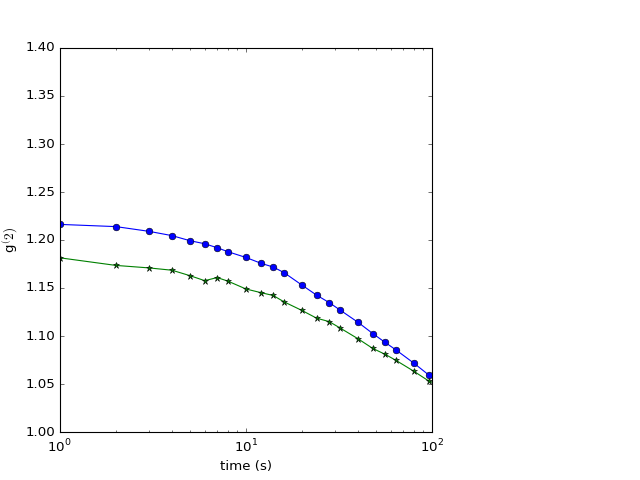

In [25]:
one_time_movie(result_g2, lag, movie_name="one_time.mp4", interval=25, fps=15)

